**# Model Training using AlexNet Architecture#**

In [ ]:
import os
import numpy as np
import random
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
#paths and parameters
TRAIN_DIR = '/workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/preprocessed_data/train'
VAL_DIR = '/workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/preprocessed_data/validation'
TEST_DIR = '/workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/preprocessed_data/test'
MODEL_PATH = '/workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5'
INPUT_SHAPE = (128, 128, 1)
EPOCHS = 50
BATCH_SIZE = 128
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}

In [ ]:
class NPYDataGenerator(Sequence):
    def __init__(self, root_dir, class_names, class_to_idx, batch_size=32, shuffle=True):
        self.root_dir = root_dir
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.samples = []
        for class_name in class_names:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.endswith('.npy'):
                    self.samples.append((os.path.join(class_dir, fname), class_to_idx[class_name]))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = []
        y = []
        for fpath, label in batch_samples:
            img = np.load(fpath)
            X.append(img)
            y.append(label)
        X = np.stack(X)
        y = np.array(y)
        y = to_categorical(y, num_classes=len(self.class_names))
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)

In [16]:
#Build AlexNet model
def build_my_model(input_shape=(128, 128, 1), num_classes=7):
    model = Sequential()
    model.add(Conv2D(48, (11, 11), strides=4, padding='same', input_shape=input_shape))  # 48 instead of 96
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(128, (5, 5), padding='same'))  # 128 instead of 256
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(192, (3, 3), padding='same', activation='relu'))  # 192 instead of 384
    model.add(Conv2D(192, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))  # 128 instead of 256
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))  # 512 instead of 4096
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [ ]:
# Use simple NPY data generator without augmentation
train_gen = NPYDataGenerator(
    TRAIN_DIR, CLASS_NAMES, CLASS_TO_IDX,
    batch_size=BATCH_SIZE,
)

print("Using NPYDataGenerator without augmentation for training data")
print(f"Number of training batches: {len(train_gen)}")


In [17]:
# Create generators for training and validation
train_gen = NPYDataGenerator(TRAIN_DIR, CLASS_NAMES, CLASS_TO_IDX, batch_size=BATCH_SIZE)
val_gen = NPYDataGenerator(VAL_DIR, CLASS_NAMES, CLASS_TO_IDX, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_gen)}")
print(f"Number of validation batches: {len(val_gen)}")

Number of training batches: 181
Number of validation batches: 46


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#Training will stop when the validation accuracy is not improving for 10 consecutive epochs.

In [19]:
model = build_my_model(input_shape=INPUT_SHAPE, num_classes=len(CLASS_NAMES))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2335 - loss: 1.8492
Epoch 1: val_accuracy improved from -inf to 0.24900, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.2337 - loss: 1.8488 - val_accuracy: 0.2490 - val_loss: 1.7873
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3748 - loss: 1.5731
Epoch 2: val_accuracy improved from 0.24900 to 0.39570, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.3749 - loss: 1.5728 - val_accuracy: 0.3957 - val_loss: 1.5481
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4426 - loss: 1.4250
Epoch 3: val_accuracy did not improve from 0.39570
181/181 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.4427 - loss: 1.4249 - val_accuracy: 0.3685 - val_loss: 1.6182
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4840 - loss: 1.3416
Epoch 4: val_accuracy improved from 0.39570 to 0.47945, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.4840 - loss: 1.3415 - val_accuracy: 0.4795 - val_loss: 1.3370
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5165 - loss: 1.2605
Epoch 5: val_accuracy did not improve from 0.47945
181/181 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.5164 - loss: 1.2606 - val_accuracy: 0.4536 - val_loss: 1.3805
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5258 - loss: 1.2228
Epoch 6: val_accuracy did not improve from 0.47945
181/181 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.5258 - loss: 1.2227 - val_accuracy: 0.4725 - val_loss: 1.3589
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5515 - loss: 1.1677
Epoch 7: val_accuracy improved from 0.47945 to 0.50772, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.5515 - loss: 1.1678 - val_accuracy: 0.5077 - val_loss: 1.2691
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5721 - loss: 1.1118
Epoch 8: val_accuracy improved from 0.50772 to 0.51673, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.5721 - loss: 1.1119 - val_accuracy: 0.5167 - val_loss: 1.2626
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5900 - loss: 1.0730
Epoch 9: val_accuracy improved from 0.51673 to 0.52575, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.5900 - loss: 1.0730 - val_accuracy: 0.5257 - val_loss: 1.2395
Epoch 10/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5938 - loss: 1.0487
Epoch 10: val_accuracy did not improve from 0.52575
181/181 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5939 - loss: 1.0487 - val_accuracy: 0.5166 - val_loss: 1.2591
Epoch 11/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6198 - loss: 0.9873
Epoch 11: val_accuracy improved from 0.52575 to 0.52610, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.6198 - loss: 0.9875 - val_accuracy: 0.5261 - val_loss: 1.2562
Epoch 12/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6329 - loss: 0.9588
Epoch 12: val_accuracy did not improve from 0.52610
181/181 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6328 - loss: 0.9589 - val_accuracy: 0.4571 - val_loss: 1.4393
Epoch 13/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6538 - loss: 0.8998
Epoch 13: val_accuracy improved from 0.52610 to 0.53546, saving model to /workspaces/Emotion_detector/notebooks/FC110533_Dulith/base_model/model/modeldp1_best.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.6537 - loss: 0.8999 - val_accuracy: 0.5355 - val_loss: 1.2577
Epoch 14/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6749 - loss: 0.8503
Epoch 14: val_accuracy did not improve from 0.53546
181/181 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6748 - loss: 0.8505 - val_accuracy: 0.5181 - val_loss: 1.3038
Epoch 15/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6823 - loss: 0.8345
Epoch 15: val_accuracy did not improve from 0.53546
181/181 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.6822 - loss: 0.8346 - val_accuracy: 0.5188 - val_loss: 1.3200
Epoch 16/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6864 - loss: 0.8178
Epoch 16: val_accuracy did not improve from 0.53546
181/181 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.6864 - loss: 0.8180 - val_accuracy: 0.5251 - val_loss: 1.3983
Epoch 17/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7080 - loss: 0.7583
Epoch 17: val_accuracy did n

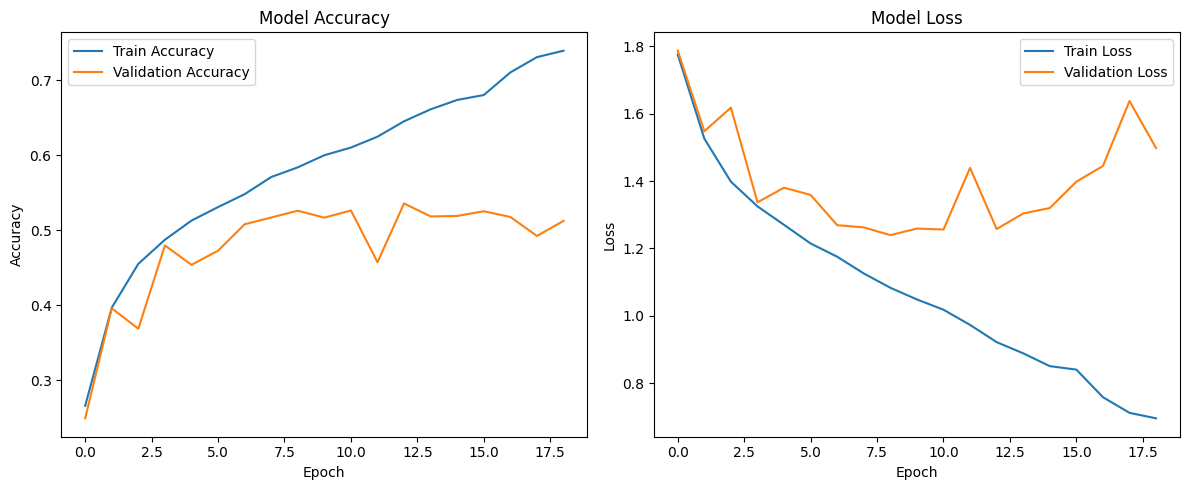

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
history = model.history.history

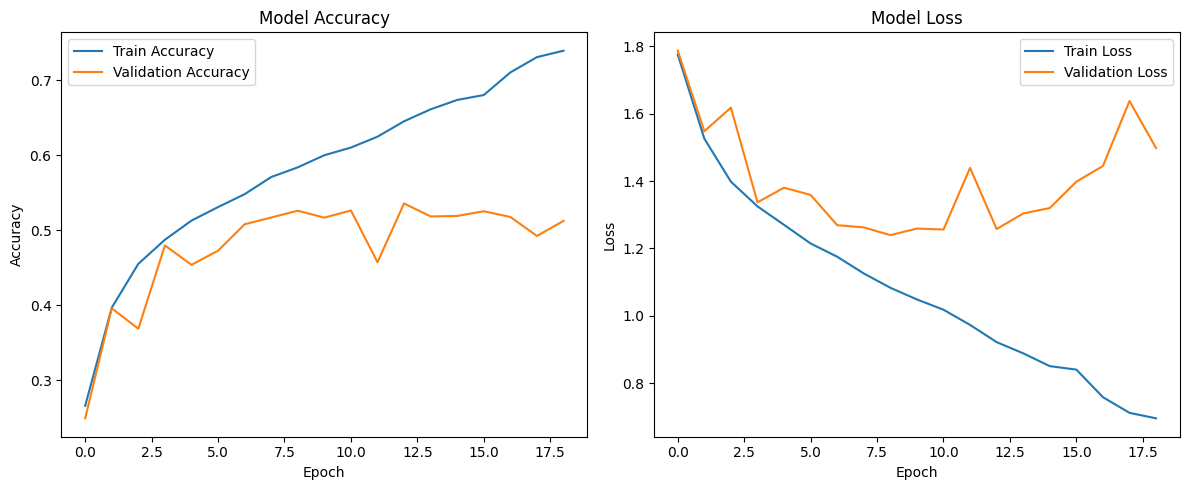

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
